<a href="https://colab.research.google.com/github/rms5010/first-dl-project/blob/main/LSTM_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 예측 모델로 유튜브 알고리즘 예측해보기

## 1. 라이브러리 불러오기

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## 2. 데이터 불러오기

In [12]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/2025-1/dl/deep-learning-project/KR_youtube_trending_data.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.  6일 이상 등장한 video_id만 추출

In [13]:
video_counts = df['video_id'].value_counts()
video_ids = video_counts[video_counts >= 6].index.tolist()

## 4. 시퀀스 생성 함수 정의

In [14]:
def create_sequences(values, window_size):
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:i+window_size])
        y.append(values[i+window_size])
    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y

## 5. 각 video_id에 대해 LSTM 학습 및 예측

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


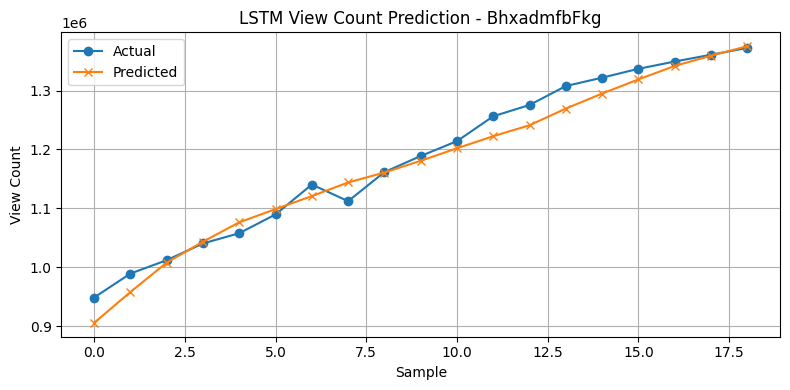

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


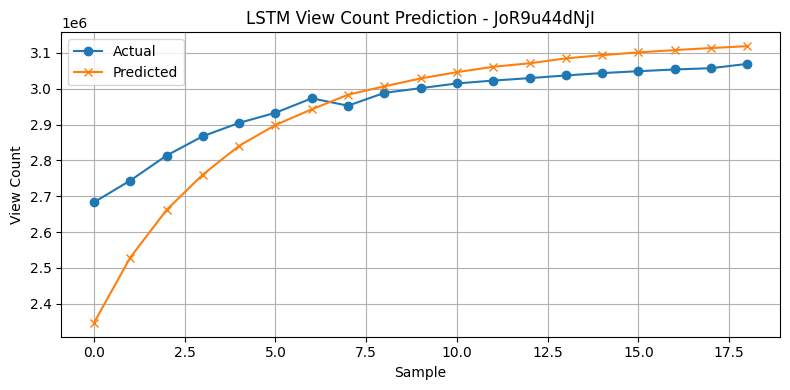

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


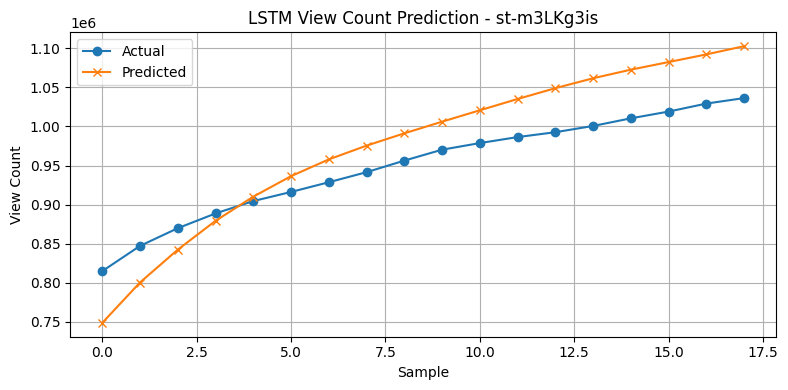

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


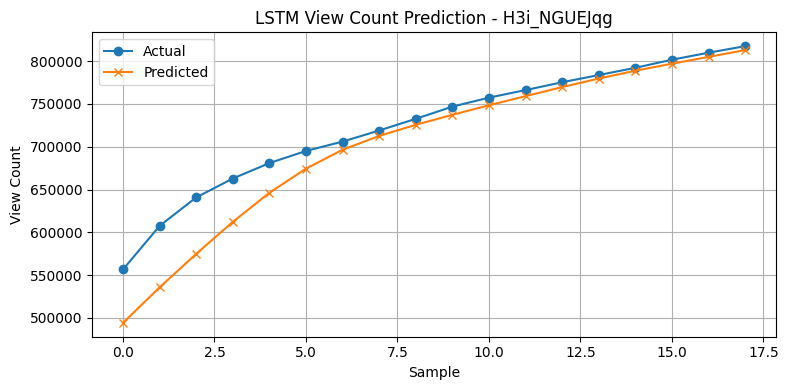

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


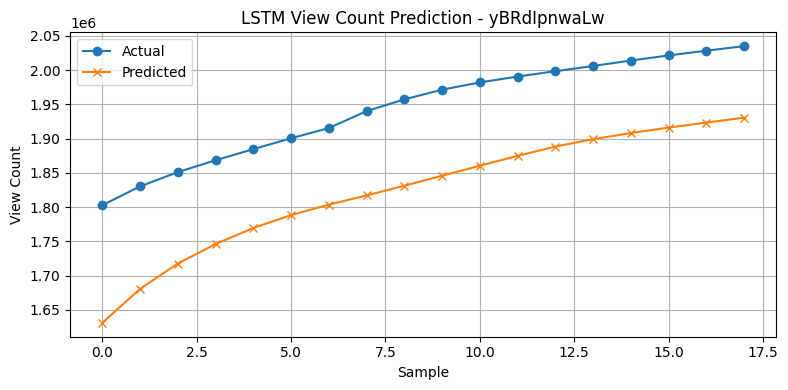

In [15]:
results = {}
window_size = 5

# 정규화
scaler = MinMaxScaler()

for vid in video_ids[:5]:  # 최대 5개까지만 실험
    sub_df = df[df['video_id'] == vid].sort_values('trending_date')
    views = sub_df['view_count'].astype(float).values
    if len(views) <= window_size:
        continue

    views_scaled = scaler.fit_transform(views.reshape(-1, 1)).flatten()
    X, y = create_sequences(views_scaled, window_size)

    # 모델 정의 및 학습
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # 예측 및 평가
    y_pred_scaled = model.predict(X).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    # 결과 저장
    results[vid] = {
        'actual': y,
        'predicted': y_pred,
        'mse': mse,
        'mae': mae
    }

    # 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(y_true, label='Actual', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title(f"LSTM View Count Prediction - {vid}")
    plt.xlabel("Sample")
    plt.ylabel("View Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 6. 성능 지표 출력

In [16]:
for vid, res in results.items():
    print(f"\n[{vid}] MSE: {res['mse']:.2f}, MAE: {res['mae']:.2f}")


[BhxadmfbFkg] MSE: 1397957705628.13, MAE: 1174805.80

[JoR9u44dNjI] MSE: 8670341492148.30, MAE: 2936845.30

[st-m3LKg3is] MSE: 962433525639.27, MAE: 975773.18

[H3i_NGUEJqg] MSE: 504241118563.94, MAE: 703956.11

[yBRdIpnwaLw] MSE: 3334311941622.78, MAE: 1824015.14


## 7. 예측 성능 요약표

In [17]:
summary = pd.DataFrame([
    {'video_id': vid, 'MSE': res['mse'], 'MAE': res['mae']}
    for vid, res in results.items()
])
display(summary.sort_values('MAE'))

,video_id,MSE,MAE
3,H3i_NGUEJqg,5.042411e+11,7.039561e+05
2,st-m3LKg3is,9.624335e+11,9.757732e+05
0,BhxadmfbFkg,1.397958e+12,1.174806e+06
4,yBRdIpnwaLw,3.334312e+12,1.824015e+06
1,JoR9u44dNjI,8.670341e+12,2.936845e+06


## 8. 예측값 기반 영상 랭킹

In [18]:
ranking = sorted([
    (vid, preds['predicted'][-1]) for vid, preds in results.items()
], key=lambda x: -x[1])

for rank, (vid, pred) in enumerate(ranking[:5], 1):
    print(f"{rank}. Video {vid} - 예상 조회수 {pred:.0f}")

1. Video JoR9u44dNjI - 예상 조회수 3118932
2. Video yBRdIpnwaLw - 예상 조회수 1930628
3. Video BhxadmfbFkg - 예상 조회수 1375365
4. Video st-m3LKg3is - 예상 조회수 1102672
5. Video H3i_NGUEJqg - 예상 조회수 813008


## 9. KMeans 클러스터링

In [19]:
from sklearn.cluster import KMeans
import seaborn as sns

<Axes: xlabel='mean_view', ylabel='std_view'>

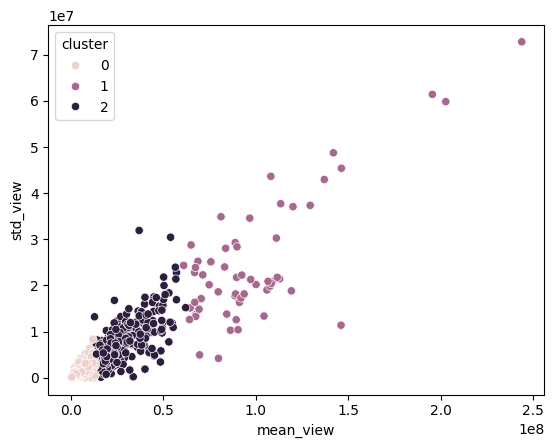

In [20]:
# 평균/표준편차 기반 피처 생성
df_stat = df.groupby('video_id').agg({
    'view_count': ['mean', 'std', 'max']
}).reset_index()
df_stat.columns = ['video_id', 'mean_view', 'std_view', 'max_view']

# NaN 값 처리
df_stat.fillna(0, inplace=True)

# 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_stat['cluster'] = kmeans.fit_predict(df_stat[['mean_view', 'std_view']])

# 시각화 예시
import seaborn as sns
sns.scatterplot(data=df_stat, x='mean_view', y='std_view', hue='cluster')